In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point,Polygon
import pyproj

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Reading the two imported datasets - Energy consumption by POSTCODE & Geospatial data by POSTCODE

dfenergycon = pd.read_csv('/kaggle/input/energy-consumption-by-postcode-uk/Energy_Consumption_UK_split_by_post_codes.csv')
dfgeo = pd.read_csv('/kaggle/input/reference-uk-postcodes-with-latitude-and-longitude/ukpostcodes.csv')

/kaggle/input/geojson-uk/NUTS3_Jan_2018_UGCB_in_the_UK_2022_4317812938987021855.geojson
/kaggle/input/energy-consumption-by-postcode-uk/Energy_Consumption_UK_split_by_post_codes.csv
/kaggle/input/reference-uk-postcodes-with-latitude-and-longitude/ukpostcodes.csv


In [2]:
#Timestamping the dataframes and cleaning the postcodes

year = '2024'
month = '02'
day = '01'
dfenergyconfiltered = dfenergycon[dfenergycon['POSTCODE'].str.len() > 4]
dfenergyconfiltered = dfenergyconfiltered.copy()
dfenergyconfiltered['ingestion_year'] = year
dfenergyconfiltered['ingestion_month'] = month
dfenergyconfiltered['ingestion_day'] = day

dfgeofiltered = dfgeo[dfgeo['postcode'].str.len() > 4]
dfgeofiltered = dfgeofiltered.copy()
dfgeofiltered['ingestion_year'] = year
dfgeofiltered['ingestion_month'] = month
dfgeofiltered['ingestion_day'] = day

In [3]:
print("Energy Consumption Data-Set")
display(dfenergyconfiltered)
print("Geospatial Data-Set : with coordinates for UK Postcodes")
display(dfgeofiltered)

Energy Consumption Data-Set


,POSTCODE,Number of meters,Consumption (kWh),Mean consumption (kWh),Median consumption (kWh),ingestion_year,ingestion_month,ingestion_day
1,AB10 1AU,14,60037.7,4288.407143,3479.20,2024,02,01
2,AB10 1BA,8,15282.9,1910.362500,2051.45,2024,02,01
3,AB10 1FL,21,46042.0,2192.476191,1957.70,2024,02,01
4,AB10 1QH,11,43274.7,3934.063636,3139.70,2024,02,01
5,AB10 1QS,16,23146.7,1446.668750,1050.25,2024,02,01
...,...,...,...,...,...,...,...,...
235197,ZE3 9JU,20,123322.3,6166.115000,6920.75,2024,02,01
235198,ZE3 9JW,8,81863.0,10232.875000,10914.05,2024,02,01
235199,ZE3 9JX,14,109263.0,7804.500000,8166.60,2024,02,01
235200,ZE3 9JY,13,89251.8,6865.523077,6601.00,2024,02,01


Geospatial Data-Set : with coordinates for UK Postcodes


,id,postcode,latitude,longitude,ingestion_year,ingestion_month,ingestion_day
0,1,AB10 1XG,57.144156,-2.114864,2024,02,01
1,2,AB10 6RN,57.137871,-2.121487,2024,02,01
2,3,AB10 7JB,57.124274,-2.127206,2024,02,01
3,4,AB11 5QN,57.142701,-2.093295,2024,02,01
4,5,AB11 6UL,57.137468,-2.112455,2024,02,01
...,...,...,...,...,...,...,...
1794529,2711464,YO7 4FB,54.243953,-1.472731,2024,02,01
1794530,2711465,YO7 9DN,54.232597,-1.328747,2024,02,01
1794531,2711466,YO8 4FS,53.779924,-1.069318,2024,02,01
1794532,2711467,YO8 6DX,53.809575,-0.923888,2024,02,01


In [4]:
dfgeofiltered['TRIMMED_POSTCODE'] = dfgeofiltered['postcode'].apply(lambda x: x[:4])
dfgeomean = dfgeofiltered.groupby('TRIMMED_POSTCODE')[['latitude', 'longitude']].mean().reset_index()

In [5]:
#Clean data to Identify regions with high and low energy consumption per meter.

dfenergyconfiltered['TRIMMED_POSTCODE'] = dfenergyconfiltered['POSTCODE'].apply(lambda x: x[:4])
dfenergyconfilteredmean = dfenergyconfiltered.groupby('TRIMMED_POSTCODE')[['Number of meters', 'Consumption (kWh)']].sum().reset_index()
dfenergyconfilteredmean['Mean Consumption per meter'] = dfenergyconfilteredmean['Consumption (kWh)']/dfenergyconfilteredmean['Number of meters']
dfebergyconplot = dfenergyconfilteredmean[['TRIMMED_POSTCODE', 'Mean Consumption per meter']]

In [6]:
#plt.figure(figsize = (10,6))
#sns.heatmap(dfplot, cmap = 'YlGnBu', annot = True, fmt = "f") 
#plt.xlabel("Number of meters")
#plt.ylabel("Consumption_per_meter")
#plt.show()

#Some nifty visualizations

fig = px.scatter(y=dfebergyconplot['Mean Consumption per meter'], x=dfebergyconplot['TRIMMED_POSTCODE'])
fig.show()

#dfebergyconplot.plot.scatter(x = 'TRIMMED_POSTCODE', y = 'Consumption_per_meter', color = 'red', marker = 'o')
#plt.title('Scatter Plot - Consumption_per_meter / Postcode')
#plt.ylabel('Consumption_per_meter')

In [7]:
print('\033[1m' + "Describing the data to scope out outliers and segregate the data by quartiles")
print('\033[0m')
print(dfebergyconplot.describe()['Mean Consumption per meter'])
fig = px.box(dfebergyconplot, y = 'Mean Consumption per meter')
fig.show()

Describing the data to scope out outliers and segregate the data by quartiles

count     2905.000000
mean      5676.372690
std       1398.563333
min       1485.431250
25%       4776.085863
50%       5467.597495
75%       6396.127876
max      30099.023077
Name: Mean Consumption per meter, dtype: float64


In [8]:
#Joining the two dataframes to include latitudes and longitudes
dfjoin = dfgeomean.merge(dfebergyconplot, on = 'TRIMMED_POSTCODE', how = 'inner')

In [9]:
#Loading in the shape-file for United kingdom
uk = gpd.read_file("/kaggle/input/geojson-uk/NUTS3_Jan_2018_UGCB_in_the_UK_2022_4317812938987021855.geojson")

In [10]:
crs = pyproj.CRS("epsg:4326")
geometry = [Point(xy) for xy in zip(dfjoin['longitude'], dfjoin['latitude'])]
geo_df = gpd.GeoDataFrame(dfjoin, crs=crs, geometry=geometry)

Text(0.5, 1.0, 'Energy Consumption by postcode')

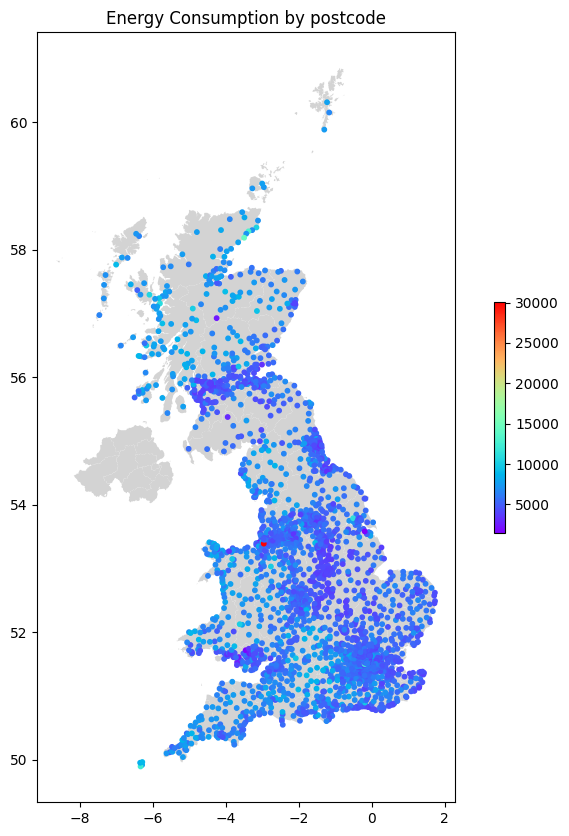

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
uk.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
#geo_df.plot(ax=ax, alpha = 0.01)
geo_df.plot(column = 'Mean Consumption per meter', ax=ax, cmap = 'rainbow',legend = True, legend_kwds={'shrink': 0.3}, markersize = 10)
ax.set_title('Energy Consumption by postcode')